In [1]:
from pathlib import Path
import numpy as np
import nibabel as nib
import dipy.data as dpd
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
from dipy.reconst.fwdti import FreeWaterTensorModel
from beltrami import BeltramiModel
from matplotlib import pyplot as plt

/Users/qiqiliang/opt/anaconda3/envs/afq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print('Loading data...')

cwd = Path.cwd()
parent_dir = cwd.parent
cenir_dir = parent_dir / 'data' / 'CENIR'
fdwi = cenir_dir / 'dwi_bias_corrected.nii.gz'
fbvals = cenir_dir / 'bvals'
fbvecs = cenir_dir / 'bvecs'
fmask = cenir_dir / 'binary_mask.nii.gz'

Loading data...


In [3]:
# data, gtab = dpd.read_cenir_multib()

In [14]:
bvals, bvecs = read_bvals_bvecs(str(fbvals), str(fbvecs))
data =  nib.load(str(fdwi)).get_fdata() # changed from .get_data -> .get_fdata

In [15]:
# single-shell (acquired only with b = 1000)
bval_mask = np.logical_or(bvals == 0, bvals > 990)
data_single = data[:, :, :, bval_mask]
bvals_single = bvals[bval_mask] * 10**-3  # rescaling bvals for Beltrami
bvecs_single = bvecs[bval_mask, :]
gtab_single = gradient_table(bvals_single, bvecs_single, b0_threshold=0)

In [16]:
# multi-shell(data with b = 200, 400 and 1000)
bval_mask = bvals <= 1050
data_multi = data[:, :, :, bval_mask]
bvals_multi = bvals[bval_mask] * 10**-3  # rescaling bvals for Beltrami
bvecs_multi = bvecs[bval_mask, :]
gtab_multi = gradient_table(bvals_multi, bvecs_multi, b0_threshold=0)

In [18]:
# loadind mask (previously computed with fsl bet)
mask = nib.load(str(fmask)).get_fdata() # changed from .get_data -> .get_fdata
mask = mask.astype(bool)

In [19]:
# slicing data (for faster computation)
data_single = data_single[17:89, 7:97, 36:56, :]
data_multi = data_multi[17:89, 7:97, 36:56, :]
mask = mask[17:89, 7:97, 34:54]

In [20]:
# masking data
masked_single = data_single * mask[..., np.newaxis]
masked_multi = data_multi * mask[..., np.newaxis]

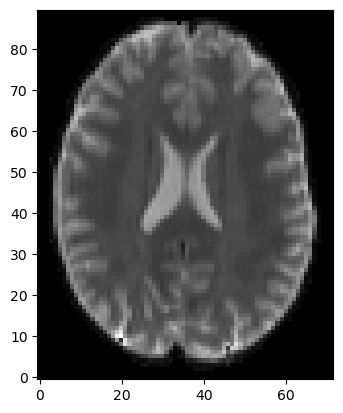

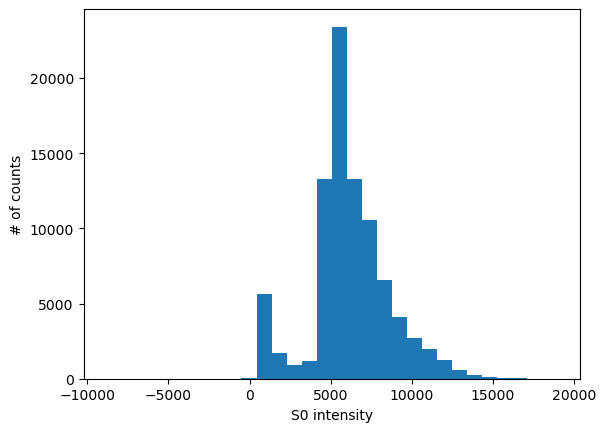

St = 8000
Sw = 12000
(72, 90, 3, 210)
(72, 90, 3, 242)


In [22]:
# unweighted image S0
S0 = np.mean(masked_multi[..., gtab_multi.b0s_mask], axis=-1) * mask

plt.figure('S0')
plt.imshow(S0[..., 8].T, origin='lower', cmap='gray')

plt.figure('S0 histogram')
plt.hist(S0[mask], bins=30)
plt.xlabel('S0 intensity')
plt.ylabel('# of counts')
plt.show()

St = 8000
Sw = 12000
print('St = '+str(St))
print('Sw = '+str(Sw))

masked_single = masked_single[..., 8:11, :]
masked_multi = masked_multi[..., 8:11, :]
mask = mask[..., 8:11]

print(masked_single.shape)
print(masked_multi.shape)

Running standard DTI (single shell)...


IndexError: boolean index did not match indexed array along dimension 2; dimension is 20 but corresponding boolean dimension is 3

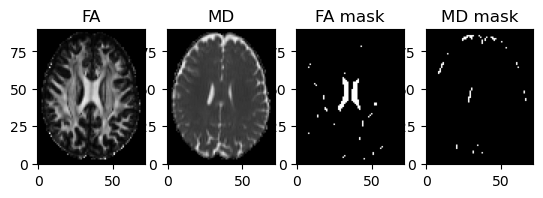

In [30]:
print('Running standard DTI (single shell)...')
dtimodel = TensorModel(gtab_single)
dtifit = dtimodel.fit(masked_single)
dti_fa = dtifit.fa * mask
dti_md = dtifit.md * mask
dti_fw = np.zeros(dti_fa.shape) * mask

WM = dti_fa > 0.7
CSF = dti_md > 2.5

plt.figure('Standard DTI')
plt.subplot(141)
# Chnaged index from 8 -> 2 or will throw out of bounds error
plt.imshow(dti_fa[..., 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
plt.title('FA')

plt.subplot(142)
plt.imshow(dti_md[..., 2].T, origin='lower', cmap='gray', vmin=0, vmax=3)
plt.title('MD')

plt.subplot(143)
plt.imshow(WM[..., 2].T, origin='lower', cmap='gray')
plt.title('FA mask')

plt.subplot(144)
plt.imshow(CSF[..., 2].T, origin='lower', cmap='gray')
plt.title('MD mask')

St = np.round(np.percentile(S0[WM], 95)) # INDEX ERROR... should WM be 3 instead of 20
Sw = np.round(np.percentile(S0[CSF], 95)) # INDEX ERROR... should CSF be 3 instead of 20
print('St = '+str(St))
print('Sw = '+str(Sw))

plt.show()

In [31]:
print('Running NLS FW-DTI (Hoy et. al)...')
bvals_scaled = gtab_multi.bvals * 1000
gtab_scaled = gradient_table(bvals_scaled, gtab_multi.bvecs)
nlsmodel = FreeWaterTensorModel(gtab_scaled)
nlsfit = nlsmodel.fit(masked_multi, mask=mask)
nls_fa = nlsfit.fa * mask
nls_md = nlsfit.md * 10**3 * mask
nls_fw = nlsfit.f * mask

Running NLS FW-DTI (Hoy et. al)...


100%|██████████| 13611/13611 [00:53<00:00, 253.17it/s]


Running Beltami FW-DTI (single-shell)...


/Users/qiqiliang/Desktop/FW-DTI-Beltrami/code/beltrami.py:464: RuntimeWarning: divide by zero encountered in divide
  f0 = 1 - np.log(S0 / Stissue) / np.log(Swater / Stissue)


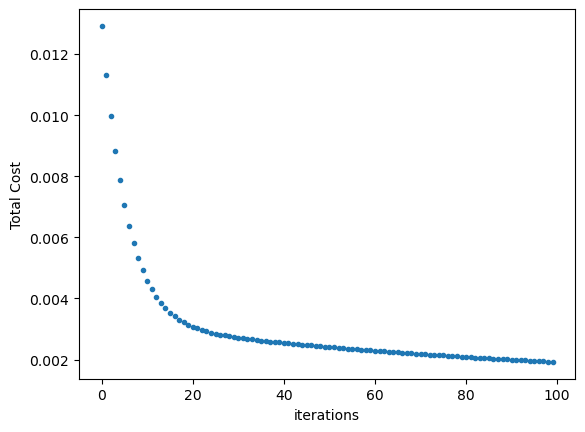

In [32]:
print('Running Beltami FW-DTI (single-shell)...')
bmodel = BeltramiModel(gtab_single, init_method='hybrid', Stissue=St, Swater=Sw,
                       iterations=100, learning_rate=0.0005)
bfit = bmodel.fit(masked_single, mask=mask)
belt_fa_s = bfit.fa * mask
belt_md_s = bfit.md * mask
belt_fw_s = bfit.fw * mask

Running Beltami FW-DTI (multi-shell)...


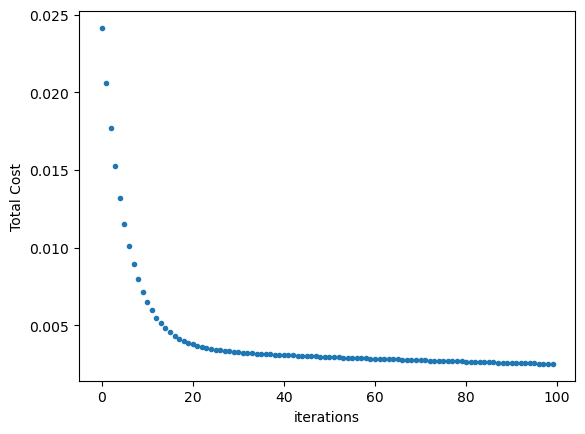

In [33]:
print('Running Beltami FW-DTI (multi-shell)...')
bmodel = BeltramiModel(gtab_multi, init_method='hybrid', Stissue=St, Swater=Sw,
                       iterations=100, learning_rate=0.0005)
bfit = bmodel.fit(masked_multi, mask=mask)
belt_fa_m = bfit.fa * mask
belt_md_m = bfit.md * mask
belt_fw_m = bfit.fw * mask

In [34]:
fig = plt.figure(figsize=(5.8, 5.44))
gs = fig.add_gridspec(ncols=4, nrows=3, hspace=0.0, wspace=0.0)

<Figure size 580x544 with 0 Axes>

In [38]:
# axes
# Index from 8 -> 2 again
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[2, 0])
ax10 = fig.add_subplot(gs[2, 1])
ax11 = fig.add_subplot(gs[2, 2])
ax12 = fig.add_subplot(gs[2, 3])

fs = 10

# column titles
ax1.set_title('DTI\n(single-shell)', fontsize=fs)
ax2.set_title('RGD FWE\n(single-shell)', fontsize=fs)
ax3.set_title('RGD FWE\n(multi-shell)', fontsize=fs)
ax4.set_title('NLS FWE\n(multi-shell) ', fontsize=fs)

# ylablels
ax1.set_ylabel('FW', fontsize=fs)
ax5.set_ylabel('MD\n' + r'$[\mu m^2 ms^{-1}]$', fontsize=fs)
ax9.set_ylabel('FA', fontsize=fs)

# removing ticks
all_axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]
for ax in all_axes:
    ax.set_xticks([])
    ax.set_yticks([])

ax1.imshow(dti_fw[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
ax2.imshow(belt_fw_s[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
ax3.imshow(belt_fw_m[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
mp = ax4.imshow(nls_fw[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
cax = fig.add_axes([0.905, 0.63, 0.025, 0.25])
cticks = [0.25, 0.5, 0.75, 1]
fig.colorbar(mp, cax=cax, ticks=cticks)

ax5.imshow(dti_md[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=3)
ax6.imshow(belt_md_s[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=3)
ax7.imshow(belt_md_m[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=3)
mp = ax8.imshow(nls_md[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=3)
cax = fig.add_axes([0.905, 0.37, 0.025, 0.25])
cticks = [0.75, 1.5, 2.25, 3]
fig.colorbar(mp, cax=cax, ticks=cticks)


ax9.imshow(dti_fa[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
ax10.imshow(belt_fa_s[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
ax11.imshow(belt_fa_m[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
mp = ax12.imshow(nls_fa[:, :, 2].T, origin='lower', cmap='gray', vmin=0, vmax=1)
cax = fig.add_axes([0.905, 0.11, 0.025, 0.25])
cticks = [0.25, 0.5, 0.75, 1]
fig.colorbar(mp, cax=cax, ticks=cticks)

plt.show()